In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example model
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.segmentation_head = UNetDecoder(64)
        self.classification_head = nn.Linear(128 * 16 * 64, 2)  # Adjusted output features for binary classification

    def forward(self, x1, x2):
        f1 = self.backbone(x1)
        f2 = self.backbone(x2)
        
        seg_out1 = self.segmentation_head(f1)
        seg_out2 = self.segmentation_head(f2)
        
        combined_features = torch.cat((f1, f2), dim=1)
        combined_features = combined_features.view(combined_features.size(0), -1)  # Flatten
        
        class_out = self.classification_head(combined_features)
        
        return seg_out1, seg_out2, class_out

class UNetDecoder(nn.Module):
    def __init__(self, in_channels):
        super(UNetDecoder, self).__init__()
        self.upconv1 = nn.ConvTranspose2d(in_channels, 96, kernel_size=2, stride=2)  # Adjusted in_channels
        self.conv1 = nn.Conv2d(96, 32, kernel_size=3, padding=1)  # Adjusted input channels
        self.upconv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.upconv1(x)
        x = self.conv1(x)
        x = self.upconv2(x)
        x = self.conv2(x)
        return x

In [39]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image, ImageDraw, ImageFont

class ForgeryDataset(Dataset):
    def __init__(self, num_samples, image_size, font_path, max_word_length=8):
        self.num_samples = num_samples
        self.image_size = image_size
        self.font_path = font_path
        self.max_word_length = max_word_length
        self.font = ImageFont.truetype(font_path, size=20)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Create random text
        original_text = ''.join(np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'), size=self.max_word_length))
        
        # Create forged text by changing one character
        forged_text = list(original_text)
        change_index = np.random.randint(0, self.max_word_length)
        forged_text[change_index] = np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'.replace(forged_text[change_index], '')))
        forged_text = ''.join(forged_text)
        
        # Render text to images
        original_image = self.render_text_to_image(original_text)
        forged_image = self.render_text_to_image(forged_text)
        
        # Randomly decide which is the pair and which is the target
        if np.random.rand() > 0.5:
            image1 = original_image
            image2 = forged_image
            label = 1  # 1 means forged
        else:
            image1 = original_image
            image2 = original_image
            label = 0  # 0 means not forged

        # Convert to tensors
        image1 = torch.from_numpy(np.array(image1)).float().unsqueeze(0) / 255.0
        image2 = torch.from_numpy(np.array(image2)).float().unsqueeze(0) / 255.0
        label = torch.tensor(label).float()
        
        return image1, image2, label

    def render_text_to_image(self, text):
        image = Image.new('L', self.image_size, color=255)
        draw = ImageDraw.Draw(image)
        draw.text((10, 10), text, font=self.font, fill=0)
        return image

# Initialize the dataset
dataset = ForgeryDataset(
    num_samples=1000, 
    image_size=(64, 256), 
    font_path='arial.ttf'  # Ensure this path is correct
)

# Create DataLoader
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [44]:
# Initialize model
model = SiameseNetwork().to(device)

# Loss functions
segmentation_loss_fn = nn.BCEWithLogitsLoss()
classification_loss_fn = nn.BCEWithLogitsLoss()
# Training loop
num_epochs = 10
class_loss_fn = nn.BCEWithLogitsLoss()

# Inside your training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        image1, image2, labels = batch
        image1, image2, labels = image1.to(device), image2.to(device), labels.to(device)
        
        # Forward pass
        seg_out1, seg_out2, class_out = model(image1, image2)
        
        # Calculate losses
        seg_loss = segmentation_loss_fn(
            F.interpolate(seg_out1, size=image1.shape[2:], mode='bilinear', align_corners=False), image1
        ) + segmentation_loss_fn(
            F.interpolate(seg_out2, size=image2.shape[2:], mode='bilinear', align_corners=False), image2
        )
        
        # Adjust labels shape if necessary (flatten or reshape)
        labels = torch.nn.functional.one_hot(labels.to(torch.int64), num_classes=2)  # Convert to one-hot
        
        # Calculate classification loss
        class_loss = class_loss_fn(class_out, labels.float().to(device))
        
        # Combine losses
        loss = seg_loss + class_loss
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Batch loss: {loss.item()}')

Epoch [1/10], Batch loss: 2.0682201385498047
Epoch [1/10], Batch loss: 2.063304901123047
Epoch [1/10], Batch loss: 2.054640293121338
Epoch [1/10], Batch loss: 2.0638654232025146
Epoch [1/10], Batch loss: 2.056570529937744
Epoch [1/10], Batch loss: 2.058990240097046
Epoch [1/10], Batch loss: 2.0613434314727783
Epoch [1/10], Batch loss: 2.064652442932129
Epoch [1/10], Batch loss: 2.0568594932556152
Epoch [1/10], Batch loss: 2.0613293647766113
Epoch [1/10], Batch loss: 2.0601022243499756
Epoch [1/10], Batch loss: 2.0587687492370605
Epoch [1/10], Batch loss: 2.049931049346924
Epoch [1/10], Batch loss: 2.0635340213775635
Epoch [1/10], Batch loss: 2.0546152591705322
Epoch [1/10], Batch loss: 2.0545568466186523
Epoch [1/10], Batch loss: 2.0516343116760254
Epoch [1/10], Batch loss: 2.0623056888580322
Epoch [1/10], Batch loss: 2.0647974014282227
Epoch [1/10], Batch loss: 2.062805652618408
Epoch [1/10], Batch loss: 2.062656879425049
Epoch [1/10], Batch loss: 2.065946102142334
Epoch [1/10], Batch

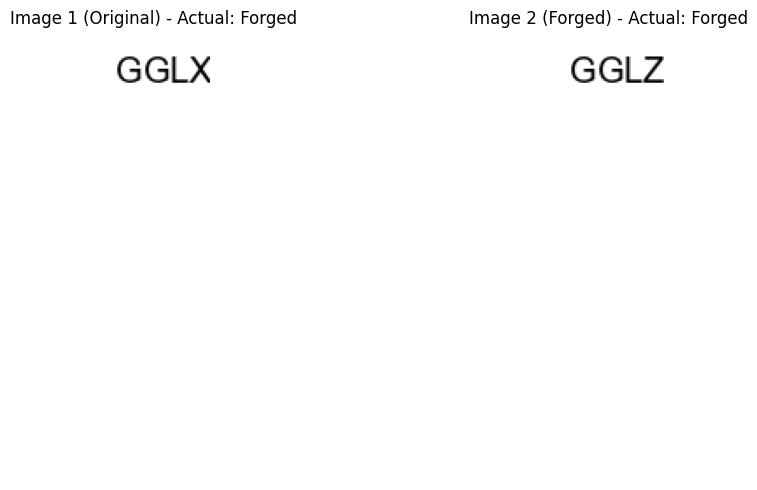

Predictions: Image 1 (Original) - Forged, Image 2 (Forged) - Forged


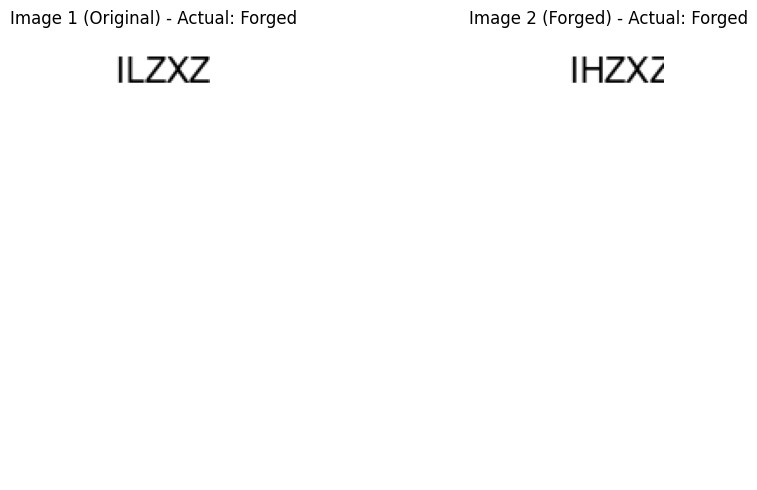

Predictions: Image 1 (Original) - Forged, Image 2 (Forged) - Forged


In [75]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Define a new ForgeryDataset for testing
class TestForgeryDataset(Dataset):
    def __init__(self, num_samples, image_size, font_path, max_word_length=8):
        self.num_samples = num_samples
        self.image_size = image_size
        self.font_path = font_path
        self.max_word_length = max_word_length
        self.font = ImageFont.truetype(font_path, size=20)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Create random text
        original_text = ''.join(np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'), size=self.max_word_length))
        
        # Create forged text by changing one character
        forged_text = list(original_text)
        change_index = np.random.randint(0, self.max_word_length)
        forged_text[change_index] = np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'.replace(forged_text[change_index], '')))
        forged_text = ''.join(forged_text)
        
        # Render text to images
        original_image = self.render_text_to_image(original_text)
        forged_image = self.render_text_to_image(forged_text)
        
        # Randomly decide which is the pair and which is the target
        if np.random.rand() > 0.5:
            image1 = original_image
            image2 = forged_image
            label = 1  # 1 means forged
            image1_id = 'Original'
            image2_id = 'Forged'
        else:
            image1 = original_image
            image2 = original_image
            label = 0  # 0 means not forged
            image1_id = 'Original'
            image2_id = 'Original'

        # Convert to tensors
        image1 = torch.from_numpy(np.array(image1)).float().unsqueeze(0) / 255.0
        image2 = torch.from_numpy(np.array(image2)).float().unsqueeze(0) / 255.0
        label = torch.tensor(label).float()
        
        return image1, image2, image1_id, image2_id, label

    def render_text_to_image(self, text):
        image = Image.new('L', self.image_size, color=255)
        draw = ImageDraw.Draw(image)
        draw.text((10, 10), text, font=self.font, fill=0)
        return image

# Initialize the test dataset
test_dataset = TestForgeryDataset(
    num_samples=2,  # Adjust number of samples as needed
    image_size=(64, 256),
    font_path='arial.ttf'  # Ensure this path is correct
)

# Create DataLoader for testing (batch size 1 since we're testing one pair at a time)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize the model (replace with your actual SiameseNetwork model)
class SiameseNetwork(torch.nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.backbone = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        self.segmentation_head = UNetDecoder(64)
        self.classification_head = torch.nn.Linear(128 * 16 * 64, 2)  # Adjusted output features for binary classification

    def forward(self, x1, x2):
        f1 = self.backbone(x1)
        f2 = self.backbone(x2)
        
        seg_out1 = self.segmentation_head(f1)
        seg_out2 = self.segmentation_head(f2)
        
        combined_features = torch.cat((f1, f2), dim=1)
        combined_features = combined_features.view(combined_features.size(0), -1)  # Flatten
        
        class_out = self.classification_head(combined_features)
        
        return seg_out1, seg_out2, class_out

class UNetDecoder(torch.nn.Module):
    def __init__(self, in_channels):
        super(UNetDecoder, self).__init__()
        self.upconv1 = torch.nn.ConvTranspose2d(in_channels, 96, kernel_size=2, stride=2)  # Adjusted in_channels
        self.conv1 = torch.nn.Conv2d(96, 32, kernel_size=3, padding=1)  # Adjusted input channels
        self.upconv2 = torch.nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(16, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.upconv1(x)
        x = self.conv1(x)
        x = self.upconv2(x)
        x = self.conv2(x)
        return x

model = SiameseNetwork()

# Function to convert tensor to numpy image
def tensor_to_image(tensor):
    return tensor.squeeze().detach().cpu().numpy()

# Function to test the model with loaded images
def test_with_images(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        for image1, image2, image1_id, image2_id, label in test_dataloader:
            image1, image2 = image1, image2  # Keep on CPU for visualization (if using GPU, remove this line)
            
            # Forward pass
            seg_out1, seg_out2, class_out = model(image1, image2)
            
            # Predicted probabilities (apply sigmoid if needed)
            predicted_probs = torch.sigmoid(class_out.squeeze()).cpu().numpy()
            predicted_class = np.argmax(predicted_probs)  # Assuming binary classification
            
            # Convert predicted class to label
            if predicted_class == 0:
                predicted_label = "Not forged"
            else:
                predicted_label = "Forged"

            # Display images and predictions
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            fig.subplots_adjust(wspace=0.5)  # Adjust space between subplots

            ax1.imshow(tensor_to_image(image1.squeeze()), cmap='gray')
            ax1.set_title(f'Image 1 ({image1_id[0]}) - Actual: {"Forged" if label.item() == 1 else "Not forged"}')
            ax1.axis('off')

            ax2.imshow(tensor_to_image(image2.squeeze()), cmap='gray')
            ax2.set_title(f'Image 2 ({image2_id[0]}) - Actual: {"Forged" if label.item() == 1 else "Not forged"}')
            ax2.axis('off')

            plt.tight_layout()
            plt.show()

            # Show predicted labels
            print(f"Predictions: Image 1 ({image1_id[0]}) - {predicted_label}, Image 2 ({image2_id[0]}) - {predicted_label}")

# Test the model with loaded images
test_with_images(model, test_dataloader)
